# *Bacillus subtilis* Diauxic Shift

Here we will attempt to reproduce the results from [Rosenthal et al. 2018](https://elifesciences.org/articles/33099). 

The shared environment will contain 50 mM Malate and 22 mM Glucose. We will assume that the environment is 1L in volume - to avoid unit conversions. 

Initial biomass is set to 0.5.

In [1]:
from copy import deepcopy

from process_bigraph import Composite
from process_bigraph.composite import ProcessTypes

from cdFBA import register_types
from cdFBA.processes.dfba import DFBA, UpdateEnvironment, Chemostat, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_chemo_spec, model_from_file
from cdFBA.utils import get_exchanges, get_substrates, get_reaction_map

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


In [2]:
model_file = 'Bacillus_subtilis_str_168.xml'

In [3]:
model_dict = {'B. subtilis': model_file}
exchanges = ['EX_ac(e)','EX_actn_R(e)', 'EX_glc_D(e)']
#'EX_mal_L(e)', 'EX_glc_D(e)'
volume = 1
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.5)

In [4]:
#Set reaction bounds
spec['B. subtilis']['config']['bounds'] = {
            'EX_o2(e)': {'lower': -2, 'upper': None},
            'DM_atp_c_': {'lower': 1, 'upper': 1}
        }
#Set initial concentrations
spec['shared environment']['concentrations']['Acetate'] = 0
spec['shared environment']['concentrations']['D-Glucose'] = 2.2
# spec['shared environment']['concentrations']['L-malate'] = 5.5
spec['shared environment']['concentrations']['R Acetoin'] = 0
spec['shared environment']['counts']['Acetate'] = 0/volume
spec['shared environment']['counts']['D-Glucose'] = 2.2/volume
# spec['shared environment']['counts']['L-malate'] = 5.5/volume
spec['shared environment']['counts']['R Acetoin'] = 0/volume

In [5]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["shared environment"],
            "global_time": ["global_time"]
        }
    }

In [6]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('DFBA', DFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('Chemostat', Chemostat)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [7]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [8]:
sim.run(10)

In [9]:
results = sim.gather_results()[('emitter',)]

In [10]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

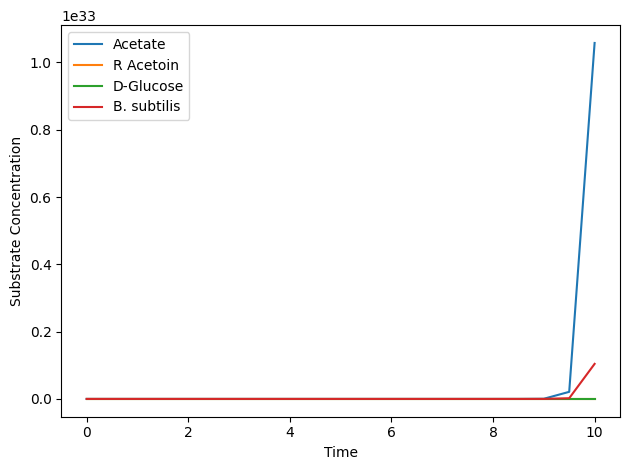

In [11]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in []:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()
#'B. subtilis', 'Acetate', 'R Acetoin'

In [12]:
results

[{'shared_environment': {'concentrations': {'Acetate': 0,
    'R Acetoin': 0,
    'D-Glucose': 2.2,
    'B. subtilis': 0.5},
   'counts': {'Acetate': 0.0,
    'R Acetoin': 0.0,
    'D-Glucose': 2.2,
    'B. subtilis': 0.5},
   'volume': 1}},
 {'shared_environment': {'counts': {'Acetate': 0.0,
    'R Acetoin': 0.0,
    'D-Glucose': 2.2,
    'B. subtilis': 0.5},
   'concentrations': {'Acetate': 0.0,
    'R Acetoin': 0.0,
    'D-Glucose': 2.2,
    'B. subtilis': 0.5},
   'volume': 1}},
 {'shared_environment': {'counts': {'Acetate': np.float64(250.0),
    'R Acetoin': 0.0,
    'D-Glucose': np.float64(2.2),
    'B. subtilis': np.float64(25.116202899653906)},
   'concentrations': {'Acetate': np.float64(250.0),
    'R Acetoin': 0.0,
    'D-Glucose': np.float64(2.2),
    'B. subtilis': np.float64(25.116202899653906)},
   'volume': 1}},
 {'shared_environment': {'counts': {'Acetate': np.float64(12808.101449826952),
    'R Acetoin': 0.0,
    'D-Glucose': np.float64(2.2),
    'B. subtilis': np.flo

In [3]:
model = model_from_file(model_file)

In [5]:
results = model.optimize()

In [6]:
results

,fluxes,reduced_costs
1H2NPTH,0.000000,-6.365316e-03
1P4H2CBXLAH,0.000000,1.831945e-19
23DHMPO,0.000000,5.753250e-18
23PDE2,0.000000,-7.472035e-19
23PDE4,0.000000,-7.472035e-19
...,...,...
rtranscription,112.666085,0.000000e+00
sink_PGPm1[c],-0.000023,0.000000e+00
sink_s,0.000000,0.000000e+00
sink_thissh[c],0.000000,0.000000e+00
